In [33]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import arch as arch
from arch import arch_model
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from scipy.stats import t
from scipy.stats import ks_1samp

In [34]:
ticker = "^GSPC"
data = yf.download(ticker, start="2010-01-01", end="2024-12-31")

[*********************100%***********************]  1 of 1 completed


Import the time series of the S&P500's prices since the start of the beginning of 2010 to the end of 2024.

In [35]:
data["Log Returns"] = np.log(data["Close"] / data["Close"].shift(1)) * 100
data = data.dropna()

The log returns of the S&P500's returns are computed.

In [36]:
data = data[["Close","Log Returns"]]

To clean the table of the time-series, reducing it to what is needed for the analysis.

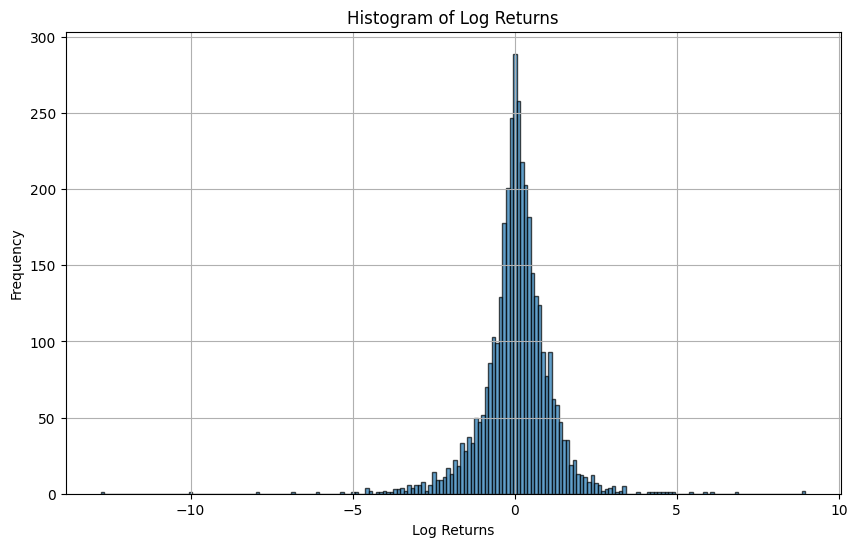

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(data["Log Returns"], bins=200, edgecolor='black', alpha=0.7)
plt.title("Histogram of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

To plot the histogram of the log returns. These look to follow the normality law.

In [38]:
ks_stat_log, p_value_log = stats.kstest(data["Log Returns"], 'norm', args=(np.mean(data["Log Returns"]), np.std(data["Log Returns"])))
print("KS statistic:", ks_stat_log, "KS test p-value:", p_value_log)

alpha = 0.05
if p_value_log < alpha:
    print("Reject the null hypothesis: Log Returns are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Log Returns appear normally distributed.")

KS statistic: 0.10053847665285282 KS test p-value: 1.2078945669775536e-33
Reject the null hypothesis: Log Returns are not normally distributed.


In [39]:
df, loc, scale = t.fit(data["Log Returns"])
ks_stat, p_value = ks_1samp(data["Log Returns"], lambda x: t.cdf(x, df, loc, scale))

print("KS Statistic:", ks_stat)
print("p-value:", p_value)

if p_value > 0.05:
    print("Fail to reject H0: Residuals follow a skewed t-distribution.")
else:
    print("Reject H0: Residuals do not follow a skewed t-distribution.")

KS Statistic: 0.020955155969027195
p-value: 0.07181161072419617
Fail to reject H0: Residuals follow a skewed t-distribution.


In [40]:
adf_test = adfuller(data["Log Returns"])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - Time-series is stationary")
else:
    print("Fail to reject the null hypothesis - Time-series is non-stationary")

Reject the null hypothesis - Time-series is stationary


Carrying out the Augmented-Dickey Fuller test allows us to know whether the log returns of the S&P500 index behave as a stationary time-series. The test leads to the conclusion that the log returns are stationary.

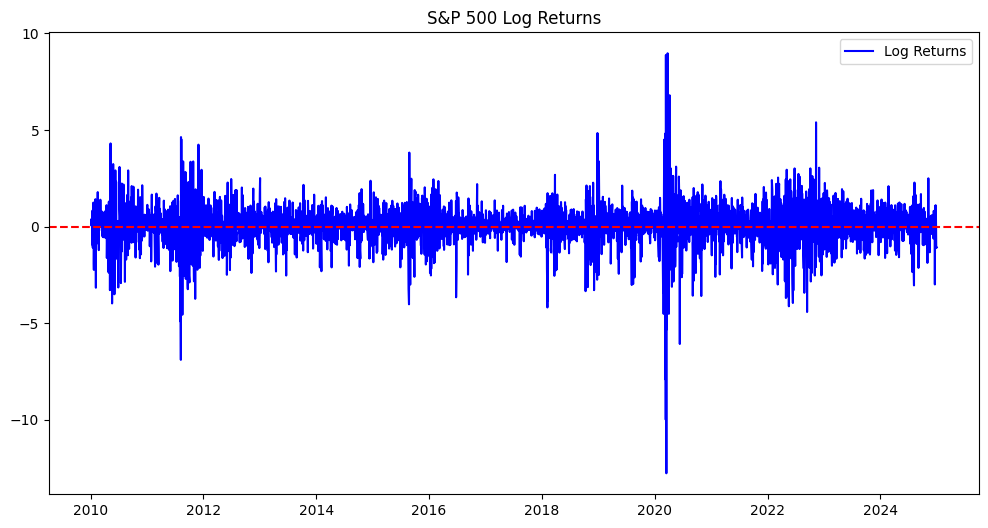

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Log Returns"], label="Log Returns", color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("S&P 500 Log Returns")
plt.legend()
plt.show()

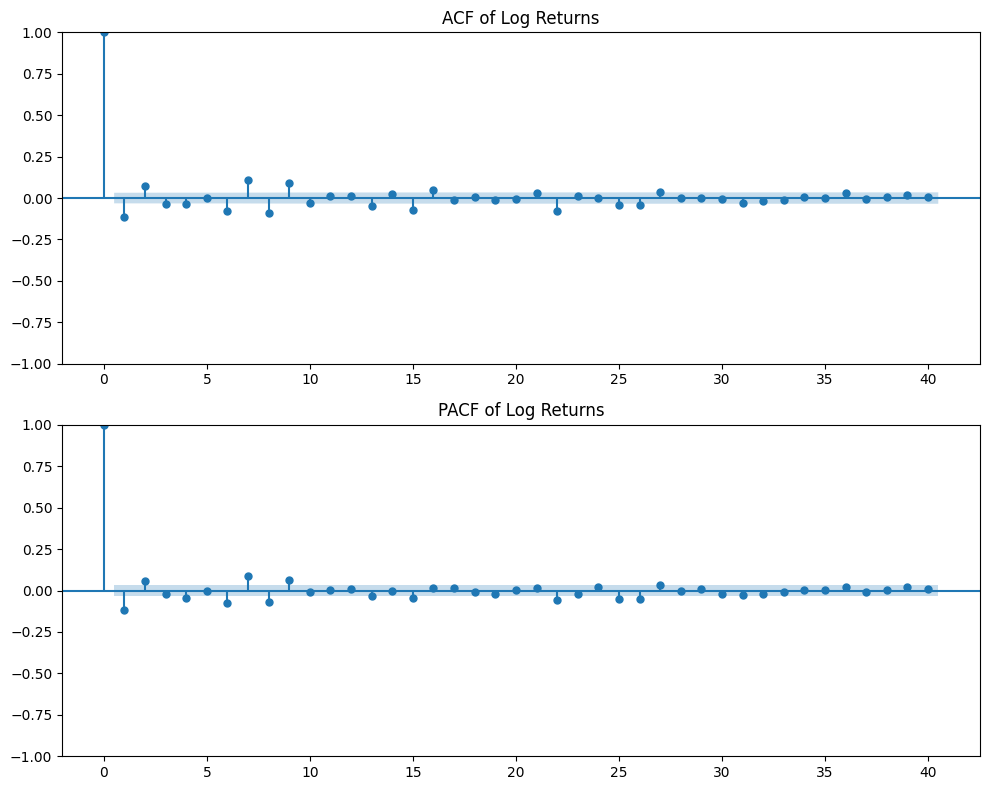

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(data["Log Returns"], lags=40, ax=axs[0])
axs[0].set_title("ACF of Log Returns")

plot_pacf(data["Log Returns"], lags=40, ax=axs[1])
axs[1].set_title("PACF of Log Returns")

plt.tight_layout()
plt.show()

Check for autocorrelation in log returns. The PACF suggests that the autocorrelation is significant for the first two lags of the log returns. This will lead to the choice of an AR(2) model, from which the residuals will be analyzed and, if they are heteroskedastic, will reveal that a GARCH is necessary to model the volatility that characterizes the time-series.

In [43]:
data["Sq. Log Returns"] = data["Log Returns"]**2

The squared log returns are computed in order to check for autocorrelations between them and their lags. In other words, autocorrelation between the squared log-returns and their lags represents a proxy of the autocorrelation between the volatilities of them, leading to the choice of the best GARCH-volatility component.

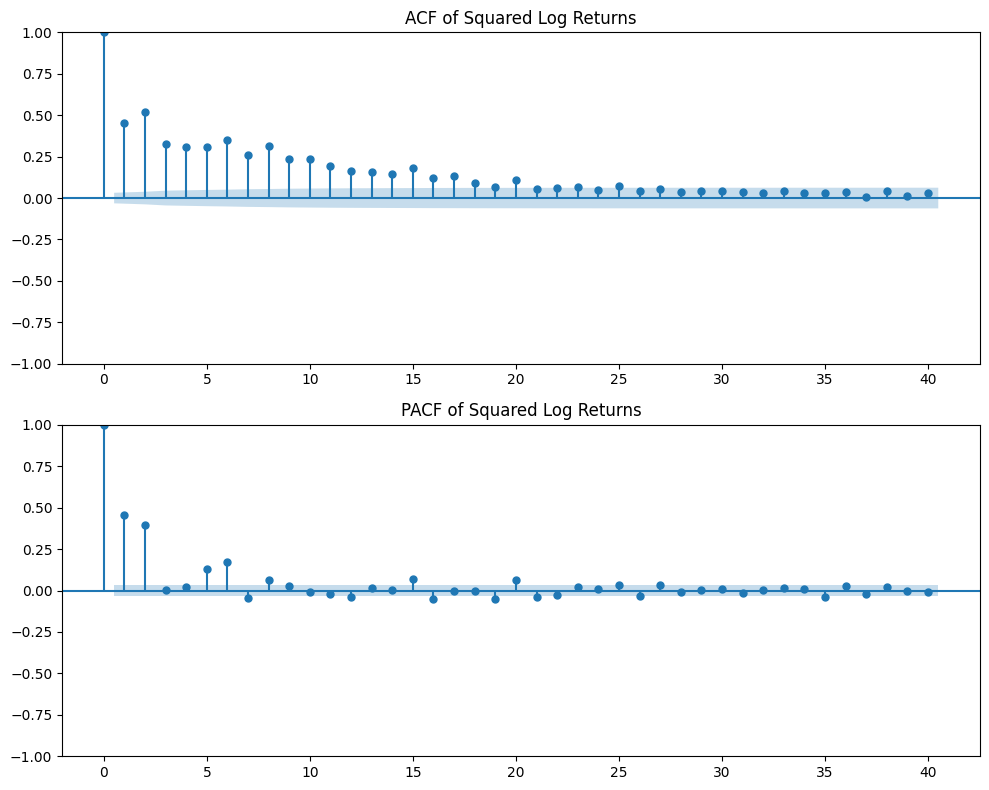

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(data["Sq. Log Returns"], lags=40, ax=axs[0])
axs[0].set_title("ACF of Squared Log Returns")

plot_pacf(data["Sq. Log Returns"], lags=40, ax=axs[1])
axs[1].set_title("PACF of Squared Log Returns")

plt.tight_layout()
plt.show()

Check for autocorrelation in volatility.

In [45]:
data_ar2 = data
data_ar2["Lag 1"] = data_ar2["Log Returns"].shift(1)
data_ar2["Lag 2"] = data_ar2["Log Returns"].shift(2)
data_ar2["Lag 6"] = data_ar2["Log Returns"].shift(6)
data_ar2["Lag 7"] = data_ar2["Log Returns"].shift(7)
data_ar2["Lag 8"] = data_ar2["Log Returns"].shift(8)
data_ar2 = data_ar2.dropna()

X = sm.add_constant(data_ar2[["Lag 1","Lag 2","Lag 6","Lag 7","Lag 8"]])

ar2_model = sm.OLS(data_ar2["Log Returns"], X).fit()
print(ar2_model.summary())

residuals_ar2 = ar2_model.resid

arch_test = het_arch(residuals_ar2)

print("F-test p-value:",arch_test[3])

if arch_test[3] < 0.05:
    print("The Engle's test detects heteroskedasticity.")
else:
    print("There is no heteroskedasticity: a GARCH model is not needed.")

                            OLS Regression Results                            
Dep. Variable:            Log Returns   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     26.75
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           1.16e-26
Time:                        18:04:44   Log-Likelihood:                -5598.6
No. Observations:                3764   AIC:                         1.121e+04
Df Residuals:                    3758   BIC:                         1.125e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0472      0.018      2.692

Check for heteroskedasticity in the log return's time-series. The null hypothesis-rejection makes it necessary to model volatility through a GARCH model.

In [46]:
model11 = arch_model(data["Log Returns"], vol="Garch", p=1, q=1, dist="skewt")
model_fit11 = model11.fit(disp="off")
print(model_fit11.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                       Log Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -4719.99
Distribution:      Standardized Skew Student's t   AIC:                           9451.97
Method:                       Maximum Likelihood   BIC:                           9489.38
                                                   No. Observations:                 3772
Date:                           Sun, Feb 09 2025   Df Residuals:                     3771
Time:                                   18:04:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [47]:
model21 = arch_model(data["Log Returns"], vol="Garch", p=2, q=1, dist="skewt")
model_fit21 = model21.fit(disp="off")
print(model_fit21.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                       Log Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -4716.66
Distribution:      Standardized Skew Student's t   AIC:                           9447.32
Method:                       Maximum Likelihood   BIC:                           9490.96
                                                   No. Observations:                 3772
Date:                           Sun, Feb 09 2025   Df Residuals:                     3771
Time:                                   18:04:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In the mean model, the mean return appears to be statistically different from zero.
In the volatility model, omega (the long-run variance level) results significant.
Both the alpha's (coefficients related to the past squared shocks) result significantly different from zero. Thus, past shocks affect volatility.
The beta coefficient, related to the sensitivity of the current volatility to the previous volatility, is significant. This means that periods of high volatility tend to last.
Since the sum of the three coefficients is close but still smaller than 1, this model implies high volatility persistence.
The lambda signals a fatter left tail, justifying using a skewed t-distribution instead of a normal one.

In [48]:
print(f"GARCH(1,1) - AIC: {model_fit11.aic}, BIC: {model_fit11.bic}")
print(f"GARCH(2,1) - AIC: {model_fit21.aic}, BIC: {model_fit21.bic}")

GARCH(1,1) - AIC: 9451.970253075051, BIC: 9489.382416937571
GARCH(2,1) - AIC: 9447.317275586283, BIC: 9490.964800092557


Given that the two models are as good as each other, the latter is chosen.

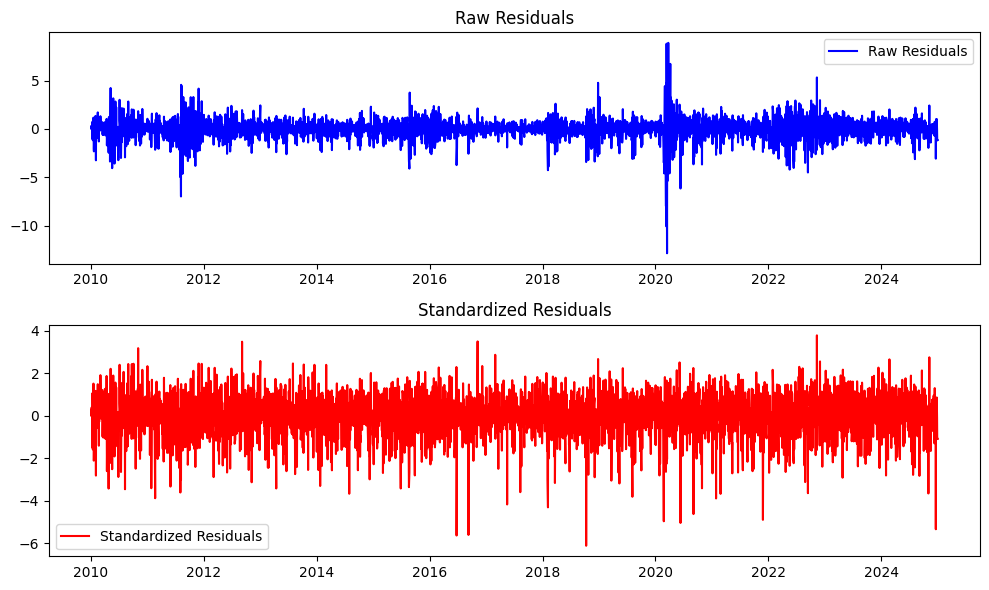

In [49]:
residuals = model_fit21.resid
std_residuals = residuals / model_fit21.conditional_volatility

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(residuals, label="Raw Residuals", color="blue")
axs[0].set_title("Raw Residuals")
axs[0].legend()

axs[1].plot(std_residuals, label="Standardized Residuals", color="red")
axs[1].set_title("Standardized Residuals")
axs[1].legend()

plt.tight_layout()
plt.show()

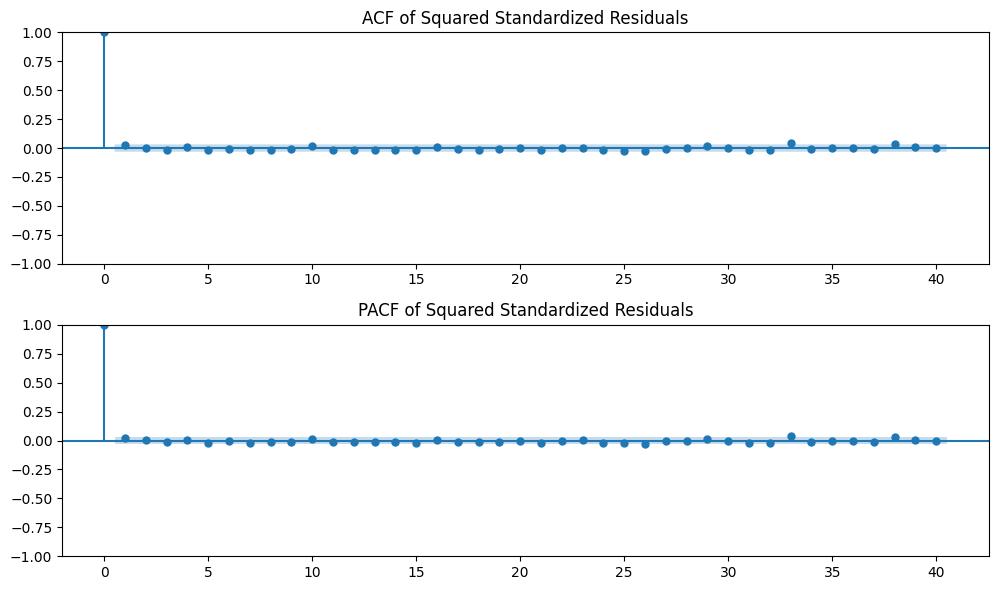

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(std_residuals**2, lags=40, ax=axs[0])
axs[0].set_title("ACF of Squared Standardized Residuals")

plot_pacf(std_residuals**2, lags=40, ax=axs[1])
axs[1].set_title("PACF of Squared Standardized Residuals")

plt.tight_layout()
plt.show()

The residuals behave as a martingale difference sequence and the model is correctly specified.

In [51]:
lb_test = acorr_ljungbox(std_residuals, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  11.044337   0.354074


To check whether the variables of the model are correlated with each other. The test fails to reject the null hypothesis, indicating that the variables are not correlated.

In [52]:
df, loc, scale = t.fit(std_residuals)
ks_stat, p_value = ks_1samp(std_residuals, lambda x: t.cdf(x, df, loc, scale))

print("KS Statistic:", ks_stat)
print("p-value:", p_value)

if p_value > 0.05:
    print("Fail to reject H0: Residuals follow a skewed t-distribution.")
else:
    print("Reject H0: Residuals do not follow a skewed t-distribution.")

KS Statistic: 0.02056275900247856
p-value: 0.08122366417885751
Fail to reject H0: Residuals follow a skewed t-distribution.


In [53]:
adf_test_residuals = adfuller(residuals)

if adf_test_residuals[1] < 0.05:
    print("Reject the null hypothesis - Time-series is stationary")
else:
    print("Fail to reject the null hypothesis - Time-series is non-stationary")

adf_test_std_res = adfuller(std_residuals)

if adf_test_std_res[1] < 0.05:
    print("Reject the null hypothesis - Time-series is stationary")
else:
    print("Fail to reject the null hypothesis - Time-series is non-stationary")

Reject the null hypothesis - Time-series is stationary
Reject the null hypothesis - Time-series is stationary


In [54]:
forecast = model_fit21.forecast(start=data.index[-1], horizon=1)
vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])
print("The volatility forecast is",vol_forecast)

The volatility forecast is 1.078601371205778


In [55]:
df, loc, scale = t.fit(std_residuals)
alpha = 0.05
VaR_95_t = t.ppf(alpha, df, loc, scale) * vol_forecast
print("1-day 95% VaR (Skewed t, as a percentage):", VaR_95_t)

1-day 95% VaR (Skewed t, as a percentage): -1.7192608008378973


In [56]:
violations_95 = (data["Log Returns"] < -VaR_95_t).sum()

total_days = len(data)
expected_violations_95 = total_days * 0.05

print("VaR 95% Violations:",violations_95,"; Expected violations:",expected_violations_95)

VaR 95% Violations: 3630 ; Expected violations: 188.60000000000002


In [57]:
def skew_t_cvar(alpha, df, loc, scale, skew, vol_forecast):
    # Compute skewed adjustment constants
    gamma = np.sqrt(df / (df - 2)) * (skew / np.sqrt(1 + skew**2))
    delta = 1 / np.sqrt(1 + skew**2)
    # Compute the skewed quantile (VaR threshold)
    c = t.ppf(1 - alpha, df)  # Standard t-distribution quantile
    c_skewed = delta * c + gamma  # Adjusted for skewness
    # Compute the probability density function (PDF) at the quantile
    pdf_c = t.pdf(c, df) / scale  # Adjusted PDF
    # Compute Expected Shortfall (Conditional VaR)
    ES = -((df + c**2) / (df - 1)) * (pdf_c / alpha) * scale * delta + loc
    return ES * vol_forecast

print("1-day 95% CVaR (Skewed t, as a percentage):",skew_t_cvar(alpha,df,loc,scale,model_fit21.params["lambda"],vol_forecast))

1-day 95% CVaR (Skewed t, as a percentage): -2.988235643697933


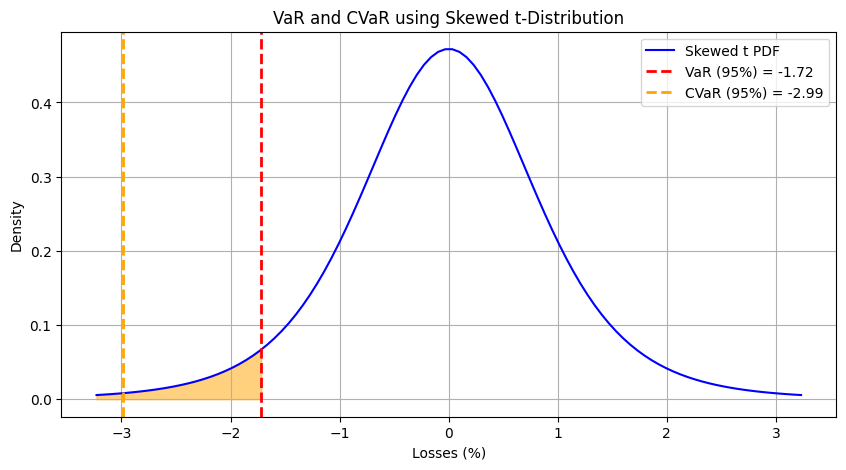

In [58]:
df, loc, scale = t.fit(std_residuals)

x = np.linspace(loc - 4*scale, loc + 4*scale, 100)
pdf_values = t.pdf(x, df, loc, scale)

plt.figure(figsize=(10, 5))
plt.plot(x, pdf_values, label="Skewed t PDF", color="blue")

plt.axvline(VaR_95_t, color="red", linestyle="--", linewidth=2, label=f"VaR (95%) = {VaR_95_t:.2f}")
plt.axvline(skew_t_cvar(alpha,df,loc,scale,model_fit21.params["lambda"],vol_forecast), color="orange", linestyle="--", linewidth=2, label=f"CVaR (95%) = {skew_t_cvar(alpha,df,loc,scale,model_fit21.params["lambda"],vol_forecast):.2f}")

x_fill = np.linspace(VaR_95_t, min(x), 100)
plt.fill_between(x_fill, t.pdf(x_fill, df, loc, scale), alpha=0.5, color="orange")

plt.title("VaR and CVaR using Skewed t-Distribution")
plt.xlabel("Losses (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
def kupiec_test(violations,T,alpha):
    POF = violations / T
    if POF == 0 or POF == 1:  # Avoid log(0) error
        return np.inf, 0.0

    LR_kupiec = -2 * ((T - violations) * np.log((alpha) / (1 - POF)) + violations * np.log(alpha / POF))

    p_value = 1 - stats.chi2.cdf(LR_kupiec, df=1)

    return LR_kupiec, p_value

LR_stat, p_value_kupiec = kupiec_test(violations_95, total_days, 1-alpha)
print(f"Kupiec LR Statistic: {LR_stat:.4f}, p-value: {p_value_kupiec:.4f}")

if p_value_kupiec < alpha:
    print("Reject H0: VaR model is not correctly specified.")
else:
    print("Do not reject H0: VaR model is correctly specified.")

Kupiec LR Statistic: -823.0168, p-value: 1.0000
Do not reject H0: VaR model is correctly specified.
